
# Analysis on Chicago bike sharing program 2022-2023
Date: 19 April 2023
Author: Nga Nguyen


## Rationale
The sharing economy in the eco-conscious era inevitably led to the rise of bike-sharing business. In the US, the City of Chicago cooperates with Lyft Bikes and Scooters to operate the Divvy bike-sharing service to promote bbicycling as an alternative mode of transportation. 

Since its launch in 2013, Divvy has expanded its fleet to 5,824 bikes that are monitored and secured through a network of 692 stations throughout Chicago. The bikes can be picked up from one station and returned to another station at any time. Previously, Divvy's marketing approach focused on creating general awareness and attracting a broad range of customers by offering flexible pricing options, such as single-ride passes, full-day passes, and annual memberships. Casual riders who purchase single-ride or full-day passes are referred to as casual riders or Customers, while those who purchase annual memberships are members or Subscribers. Divvy's financial analysts have found that Subscribers are more profitable than Customers. 

While offering pricing flexibility helps to attract more customers, the marketing team believes that maximizing the number of annual members will be crucial to future growth. Therefore, this analysis aims at examining historical bike trip data to understand the differences between the two sets of riders and to determine how to convert Customers into Subscribers.

## Data source and validation

- Data source: data is available for download here (https://divvy-tripdata.s3.amazonaws.com/index.html) for public use under agreement terms and conditions between Lyft Bikes and Scooters, LLC and the City of Chicago.
- Geo-coverage: The program covers City of Chicago area and offers 3 flexible plans: single-ride and full-day passes (so-called Customers), and annual memberships (so-called Subscribers).
- Time coverage: The available data was dated from 2013. However, due to the changing atmosphere of the sharing economy and technology, I focus only on the last 14 months 1/2022 - 2/2023.

## Data cleaning and transforming

- import to TablePlus for further analysis using SQL. Convert data types as follows:
<code>trip_id VARCHAR(255),
starttime TIME,
stoptime TIME,
bikeid INT,
tripduration INTEGER,
from_station_id INTEGER,
from_station_name VARCHAR(255),
to_station_id INTEGER,
to_station_name VARCHAR(255),
usertype VARCHAR(255),
gender VARCHAR(255),
birthyear NUMERIC,
start_lat NUMERIC,
start_lng NUMERIC,
end_lat NUMERIC,
end_lng NUMERIC</code>
- Filter out observations with invalid values: Several trips had stop time before start time, (2) 
- Put NA value in case of inconsistent data categorization, i.e. column "rideable_type" or bike type has "docked bike", which is the general category of all Divvy bikes. It should be either of the 2 sub-categories "electric bike" and "classic bike". 

## Analysis
### 1. Subscibers prefer short trips on weekdays, Casual Customers prefer long trips in weekends
Figure 1 shows the distribution of all bike trips in days of week by 2 types of users. There was a clear distinction between Subscribers, who rode more on weekdays, especially Tuesday to Thursday, vs Customers, who rode shared bike more in weekend. But given any day of the week, except Saturday, Subscribers always rode more trips than Customers. 

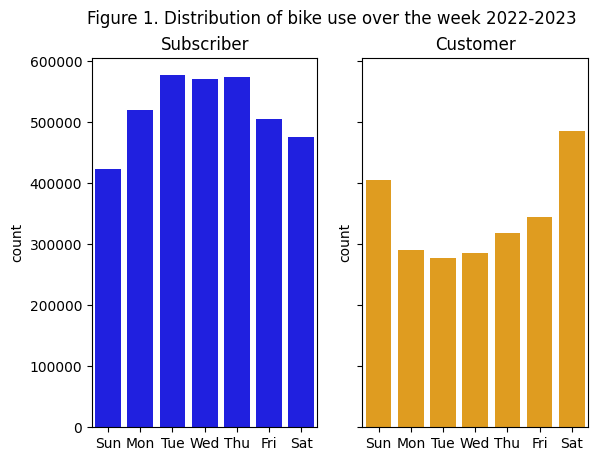

In [95]:
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd


df = pd.read_csv("day_of_week_2022_2023.csv")
for i in range(7):
    dow = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
    df.loc[df["day_of_week"] == i, "day_of_week"] = dow[i]

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.suptitle('Figure 1. Distribution of bike use over the week 2022-2023')

sns.countplot(ax=axes[0],
              data=df, x=df[df["usertype"] == "Subscriber"]["day_of_week"],
              order= ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
              color="blue"
              )
axes[0].set_title("Subscriber")
axes[0].set_xlabel('')

sns.countplot(ax=axes[1],
              data=df, x=df[df["usertype"] == "Customer"]["day_of_week"],
              order= ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
              color="orange")
axes[1].set_title("Customer")
axes[1].set_xlabel('')
plt.show()



But was it true that Subscribers rode more than Customers? It was, only if we count number of trips. The relation was totally different when we look into the duration of trips too. For further analysis on different behaviors between Subscribers and Customers, I used SQL to extract data on trip duration and Python to visualize the result in Figure 2.


<code>WITH 
trips_2022_2023 AS (SELECT * 
					FROM trips_2022
					WHERE stoptime > starttime
					UNION SELECT *
					FROM trips_2023
					WHERE stoptime > starttime)
SELECT usertype, 
        EXTRACT(EPOCH FROM SUM(stoptime - starttime)) AS sum_duration_sec,
        EXTRACT(EPOCH FROM MAX(stoptime - starttime)) AS max_duration_sec,
        EXTRACT(EPOCH FROM AVG(stoptime - starttime)) AS avg_duration_sec,
        EXTRACT('dow' FROM starttime) as day_of_week
FROM trips_2022_2023
GROUP BY usertype, day_of_week
ORDER BY day_of_week ASC, usertype;</code>

Figure 2 gives us a closer look into max, average and total length of all trips by day of weeks and usertype. On average, Subscribers used Divvy bike for about 11 mins (Thu) to 14 minutes (Sat) per trip while this number is double for Customers, whose trips were about 25 minutes (Wed) to 33 minutes (Sun) depending on the day (Figure 2a). The longest trip for Subscribers was 26hrs (1.08 days) while for Customers was 689 hrs (nearly 29 days). 

Regarding the total duration for all trips, Divvy bikes were used the most by Customers on Sat and Sun (weekends) while used by Subscribers the most on weekdays, particularly Tue, Wed and Thu. This pattern is consistent with the trend in Figure 1. An explanation for the difference in riders' behavior is that Subscribers would use docked bike for short distance to work, hence main usage on weekdays and shorter trip length on average. Meanwhile, Customers were likely to use shared bike for longer distance and leisure purposes during weekends. If these trip duration figures could be converted into real money (meaning if we can actually bill all Customers for all their trips), the revenue would be enormous and contribute significantly to the program's profit. 

However, looking at the maximum duration per trip by Customers (up to 29 days), I believe it is difficult to charge Customer for the whole length of bike rent, considering the possibility of no return or loss, invalid payment method after the initial charge, etc. This support the strategy that converting casual riders to member customers is the key for future growth. 

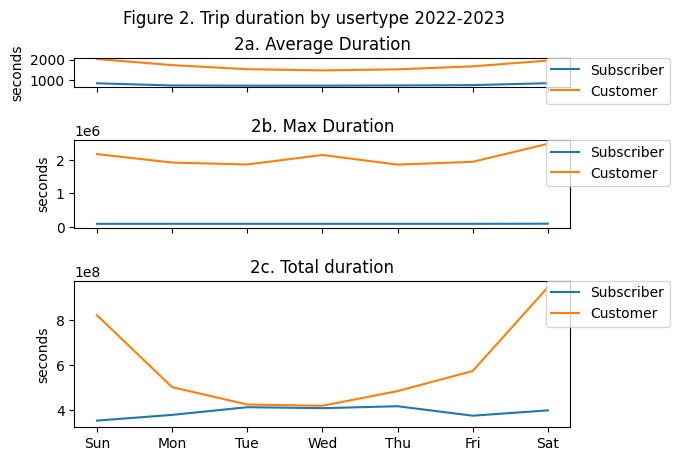

In [96]:
df_duration = pd.read_csv("trip_duration_by_dow_2022_2023.csv")
for i in range(7):
    dow = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
    df_duration.loc[df_duration["day_of_week"] == i, "day_of_week"] = dow[i]

fig2, axes = plt.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios': [1, 3, 5]})
fig2.suptitle('Figure 2. Trip duration by usertype 2022-2023')

sns.lineplot(ax=axes[0],
             data=df_duration,
             x=df_duration["day_of_week"],
             y=df_duration[df_duration["usertype"] == "Subscriber"]["avg_duration_sec"],
             label="Subscriber"
              )
sns.lineplot(ax=axes[0],
             data=df_duration,
             x=df_duration["day_of_week"],
             y=df_duration[df_duration["usertype"] == "Customer"]["avg_duration_sec"],
             label="Customer"
              )
axes[0].set_title("2a. Average Duration")
axes[0].set_xlabel('')
axes[0].set_ylabel('seconds')
axes[0].legend(loc='upper right', bbox_to_anchor=(1.2, 1), borderaxespad=0)

sns.lineplot(ax=axes[1],
             data=df_duration,
             x=df_duration["day_of_week"],
             y=df_duration[df_duration["usertype"] == "Subscriber"]["max_duration_sec"],
             label="Subscriber"
              )
sns.lineplot(ax=axes[1],
             data=df_duration,
             x=df_duration["day_of_week"],
             y=df_duration[df_duration["usertype"] == "Customer"]["max_duration_sec"],
             label="Customer"
              )
axes[1].set_title("2b. Max Duration")
axes[1].set_xlabel('')
axes[1].set_ylabel('seconds')
axes[1].legend(loc='upper right', bbox_to_anchor=(1.2, 1), borderaxespad=0)

sns.lineplot(ax=axes[2],
             data=df_duration,
             x=df_duration["day_of_week"],
             y=df_duration[df_duration["usertype"] == "Subscriber"]["sum_duration_sec"],

             label="Subscriber"
              )
sns.lineplot(ax=axes[2],
             data=df_duration,
             x=df_duration["day_of_week"],
             y=df_duration[df_duration["usertype"] == "Customer"]["sum_duration_sec"],
             label="Customer"
              )
axes[2].set_title("2c. Total duration")
axes[2].set_xlabel('')
axes[2].set_ylabel('seconds')
axes[2].legend(loc='upper right', bbox_to_anchor=(1.2, 1), borderaxespad=0)


fig2.subplots_adjust(hspace=0.6)
# fig2.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)
plt.show()


### 2. Subscribers use both types of bikes indifferently, casual Customers prefer electric bikes

Figure 3 shows the distribution of trips by bike type for 2 groups of riders. Divvy members are almost indifferent between classic and electric bike, probably for short trips and going-to-work purpose, they would use any bike available at the dock at that moment. But those use shared bikes for longer trips and leisure purpose like Customers would definitely favor electric bikes. 


Text(0.5, 1.0, 'Figure 3. Rides by bike type 2022-2023')

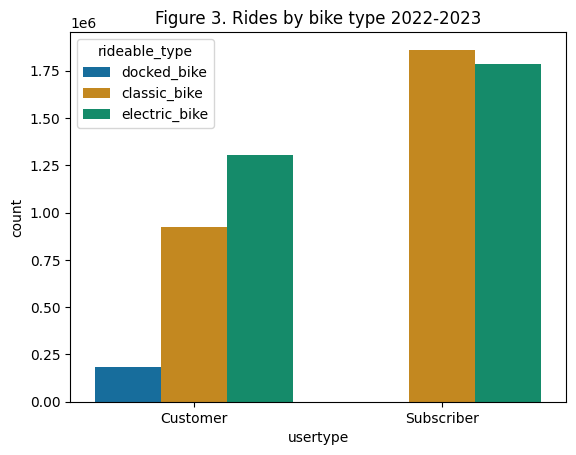

In [99]:
df_bike_type = pd.read_csv("bike_type_2022_2023.csv")
fig3 = sns.barplot(data=df_bike_type, x="usertype", y="count", hue="rideable_type", palette="colorblind")
fig3.set_title('Figure 3. Rides by bike type 2022-2023')


### 3. Subscribers ride throughout the year, Casual Customers prefers mainly summer 
Figure 4 shows the pattern of riding Divvy bikes by month or season. There was season factor in the behavior of both groups: bicyling more in the warm summer months (May to September) and less in cold months (October to April). However, riders with membership used Divvy a bit more frequently throughout the year: even in the winter the number of trips per month by this group reached more or less 200,000, tripled that number of the casual customers in winter. 


In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd


df_month = pd.read_csv("ride_by_month_2022_2023.csv")

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.suptitle('Figure 4. Distribution of bike use over the month 2022-2023')

sns.barplot(ax=axes[0],
            data=df_month, x=df_month[df_month["usertype"] == "Subscriber"]["month_of_trip"],
            y=df_month[df_month["usertype"] == "Subscriber"]["number_of_trips"],
              color="blue"
              )
axes[0].set_title("Subscriber")
axes[0].set_xlabel('')

sns.barplot(ax=axes[1],
              data=df_month, x=df_month[df_month["usertype"] == "Customer"]["month_of_trip"],
              y=df_month[df_month["usertype"] == "Customer"]["number_of_trips"],
              color="orange")
axes[1].set_title("Customer")
axes[1].set_xlabel('')
plt.show()



### 4. Subscribers use bike more after lunch and in the evening, Customers ride mostly in the evening

There were 2 peaks of rides for Subscribers: around 2-3pm (probably after a late lunch) and around midnight (possibly after last trips of public transportation). In the meantime, Customers often used

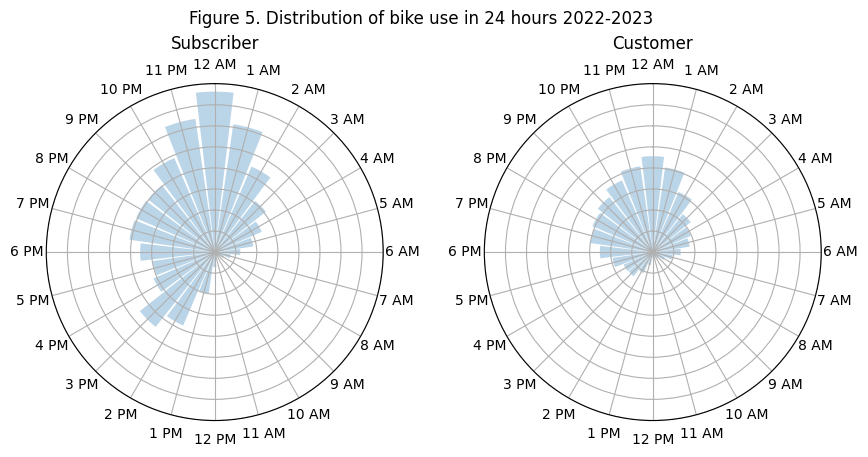

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from matplotlib.gridspec import GridSpec

df_hours_subscriber = pd.read_csv("trip_hours_subscriber_2022_2023.csv")
df_hours_customer = pd.read_csv("trip_hours_customer_2022_2023.csv")

def trans(x):
    h,m,s = map(int,x)
    return 2 * np.pi * (h + m/60 + s/3600)/24

xs = df_hours_subscriber['starttime_hour'].str.split(':')
xs = xs.apply(trans)
xs2 = df_hours_customer['starttime_hour'].str.split(':')
xs2 = xs2.apply(trans)

theta=np.arange(0,2*np.pi,2*np.pi/24)
width = (2*np.pi)/24*0.9

fig5, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5), subplot_kw={'projection': 'polar'})
fig5.suptitle('Figure 5. Distribution of bike use in 24 hours 2022-2023')
gs = GridSpec(nrows=1, ncols=2, width_ratios=[1, 1])


axes[0].bar(xs, height=df_hours_subscriber['number_of_trips'], width = width, alpha=0.3)
axes[1].bar(xs2, height=df_hours_customer['number_of_trips'], width = width, alpha=0.3)


# Make the labels go clockwise
axes[0].set_theta_direction(-1)
axes[1].set_theta_direction(-1)

#Place Zero at Top
axes[0].set_theta_offset(np.pi/2)
axes[1].set_theta_offset(np.pi/2)

#Set the circumference ticks
axes[0].set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))
axes[1].set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))

# set the label names
ticks = ['12 AM', '1 AM', '2 AM', '3 AM', '4 AM', '5 AM', '6 AM', '7 AM','8 AM','9 AM','10 AM','11 AM','12 PM', '1 PM', '2 PM', '3 PM', '4 PM',  '5 PM', '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM' ]
axes[0].set_xticklabels(ticks)
axes[1].set_xticklabels(ticks)


# suppress the radial labels
plt.setp(axes[0].get_yticklabels(), visible=False)
plt.setp(axes[1].get_yticklabels(), visible=False)

#name the subplots
axes[0].set_title("Subscriber")
axes[1].set_title("Customer")

fig5.subplots_adjust(wspace=0.3)

# plt.legend(bbox_to_anchor=(1,0), fancybox=True, shadow=True)
plt.show()
